# Исследование поведения пользователей мобильного приложения 

**Заказчик:** стартап, который продает продукты питания.

**Цель:** изучить логику поведения пользователей и решить, стоит ли менять все шрифты в мобильном приложении. 

**Гипотеза:** изменение всех шрифтов в мобильном приложении повысит прибыль от покупок. 

**Ход исследования:**
1. Обзор и предобработка данных
2. Изучение имеющейся информации о клиентах и их действиях
3. Анализ воронки продаж
4. Анализ результатов A/B тестирования
5. Формулировка выводов и рекомендаций

## Обзор и предобработка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import math as mth
import datetime as dt
import numpy as np

In [2]:
data = pd.read_csv('/datasets/logs_exp.csv', sep='\t')

data.info()

#переименуем столбцы для удобства
data= data.rename(columns = {'EventName':'event_name', 'DeviceIDHash': 'user_id', 'EventTimestamp':'date', 'ExpId':'group'})

#приведем дату к нужному формату и разобьем столбец с датой на два: со временем и без
data['datetime'] = pd.to_datetime(data['date'], unit='s')
data['date'] = pd.to_datetime(data['date'], unit='s').dt.floor('1D')

data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


,event_name,user_id,date,group,datetime
0,MainScreenAppear,4575588528974610257,2019-07-25,246,2019-07-25 04:43:36
1,MainScreenAppear,7416695313311560658,2019-07-25,246,2019-07-25 11:11:42
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25,248,2019-07-25 11:28:47
3,CartScreenAppear,3518123091307005509,2019-07-25,248,2019-07-25 11:28:47
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25,248,2019-07-25 11:48:42


In [3]:
#проверяем и удаляем дубликаты, обновляем индексы, чтобы не путаться
data.duplicated().value_counts()
data = data.drop_duplicates().reset_index()

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   index       243713 non-null  int64         
 1   event_name  243713 non-null  object        
 2   user_id     243713 non-null  int64         
 3   date        243713 non-null  datetime64[ns]
 4   group       243713 non-null  int64         
 5   datetime    243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 11.2+ MB


**Выводы:**
Данных достаточно много для исследования (более **244 тысяч** строк), в них входят id пользователей, их разбивка на три группы (две контрольные и одна экспериментальная), а также каждое совершенное пользователем событие и его время. 

Удалили несколько дублирующих строк (0,1% данных), поменяли для удобства названия столбцов, привели даты к нужному формату и разделили их на два столбца: просто дата и дата вместе с временем. 

## Изучение данных о пользователях и их действиях

Всего событий: 240887

Количество пользователей: 7534

Среднее число событий на пользователя: 32
В разбивке по событиям:
MainScreenAppear           15.57
OffersScreenAppear          6.15
CartScreenAppear            5.61
PaymentScreenSuccessful     4.50
Tutorial                    0.13
Name: event_name, dtype: float64


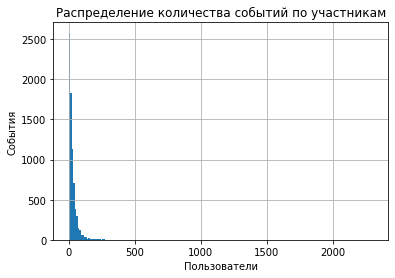

In [137]:
#посмотрим, сколько всего событий произошло за исследуемый период
print('Всего событий:',data['event_name'].count())
data['event_name'].value_counts()
print('')

#оценим количество пользователей
print('Количество пользователей:',data['user_id'].nunique())
print('')

#сколько событий в среднем совершают пользователи
print('Среднее число событий на пользователя:', round(data['event_name'].count()/data['user_id'].nunique()))
print('В разбивке по событиям:')
print(round(data['event_name'].value_counts()/data['user_id'].nunique(),2))

#посмотрим на соотношение количества событий и пользователей
data.groupby('user_id')['event_name'].count().sort_values(ascending = False).hist(bins = 200)
plt.title('Распределение количества событий по участникам')
plt.xlabel('Пользователи')
plt.ylabel('События')
plt.show()

Дата начала тестирования: 2019-07-25 00:00:00
Дата окончания тестирования: 2019-08-07 00:00:00


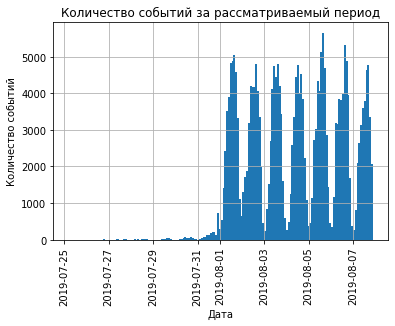

Количество событий после очистки данных: 240887
Количество пользователей после очистки данных: 7534


248    84563
246    79302
247    77022
Name: group, dtype: int64

In [5]:
#проверим, данными за какой период мы располагаем
print('Дата начала тестирования:',data['date'].min())
print('Дата окончания тестирования:',data['date'].max())

#посмотрим на графики 
data['datetime'].hist(bins=168)
plt.xticks(rotation = 'vertical')
plt.title('Количество событий за рассматриваемый период')
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.show()

#данных до 1 августа совсем мало по сравнению с остальной неделей, 
#поэтому можем убрать их: они дадут слишком мало полезных выводов
data = data.query('date >= "2019-08-01"')

#проверим, сколько данных у нас осталось после таких манипуляций
print('Количество событий после очистки данных:',data['event_name'].count())
print('Количество пользователей после очистки данных:',data['user_id'].nunique())

#проверим, что у нас остались пользователи всех трех групп
data['group'].value_counts()

**Выводы:**

У нас есть **пять видов** событий: 
1. Открытие главного экрана - 119 тысяч раз
2. Выбор товара/открытие страницы с предложением - 46,8 тысяч раз
3. Просмотр корзины - 42,6 тысячи раз
4. Успешное проведение оплаты - 34 тысячи раз
5. Обучение/инструкция - 1 тысячу раз

Тестирование проводилось с участием **7551** пользователя. 

В среднем каждый из них:
* 15 раз заходит на главную страницу 
* 6 раз открывает страницу продукта
* 5 раз открывает корзину
* 4 раза оплачивает товары
* 0 раз проходит обучение 

То есть всего в среднем - **32** события на человека.

Данные представлены за период с 25 июля по 7 августа 2019 года. Так как значительных данных до 1 августа очень мало, отбросили их и оставили неделю наблюдений: **с 1 по 7 августа** влючительно. Учитывая, что это приложение для заказа продуктов питания, неделя - адекватный период для исследований, так как в большинстве случаев людям не нужно обдумывать такой заказ несколько дней/недель.   

После удаления данных у нас осталось: **7534** пользователя (убрали **0,2%** пользователей) и **240,8 тысяч** событий (убрали **1,1%** событий).


## Анализ воронки событий

            user_id
date               
2019-08-01     3703
2019-08-02     3647
2019-08-03     3482
2019-08-04     3527
2019-08-05     3802
2019-08-06     3922
2019-08-07     3651


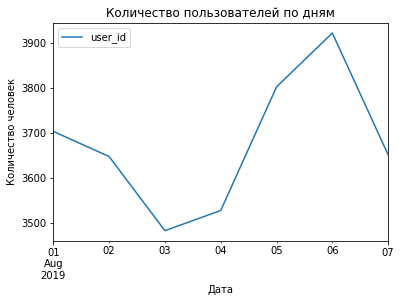

In [6]:
# вычисляем количесвто людей, совершавших какие-либо действия по дням:
print(data.groupby('date').agg({'user_id': 'nunique'}))

data.groupby('date').agg({'user_id': 'nunique'}).plot()
plt.title('Количество пользователей по дням')
plt.xlabel('Дата')
plt.ylabel('Количество человек')
plt.show()

Заметно, что в середине недели количество людей резко падает, а к концу - снова растет. В последний день количество посетителей снова уменьшается, однако это может быть связано с неполными данными за последний день (если, например, логи собираются не день в день). 

3 и 4 августа 2019 года - выходные, самый пик пришелся на вторник. Вероятно, в выходные люди предпочитают прогуляться в магазин или на рынок за продуктами самостоятельно. Однако для проверки этой гипотезы нужны данные за несколько недель.

Количество пользователей в каждом событии
event_name
MainScreenAppear           7419
OffersScreenAppear         4593
CartScreenAppear           3734
PaymentScreenSuccessful    3539
Tutorial                    840
Name: user_id, dtype: int64


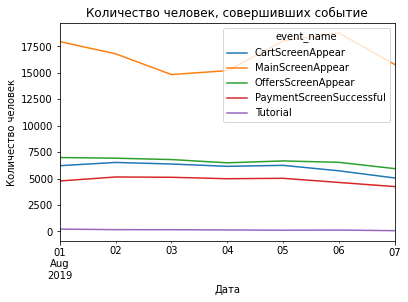

In [7]:
#узнаем, сколько пользоватаелей совершали каждое из событий 
users_cnt = data.groupby('event_name')['user_id'].nunique().sort_values(ascending = False)

print('Количество пользователей в каждом событии')
print(users_cnt)

data.pivot_table(index = 'date', columns = 'event_name', values = 'user_id', aggfunc = 'count').plot()
plt.title('Количество человек, совершивших событие')
plt.xlabel('Дата')
plt.ylabel('Количество человек')
plt.show()

На первый взгляд, воронка продаж выглядит так: Главный экран --> Страница продукта --> Корзина --> Оплата заказа.  
Страница обучения не обязательна.

По графику видно, что самое частое действие - посещение Главной страницы, однако выглядит так, что оно необязательно для совершения покупки (т.к. колебания этого события не отражаются на других). Самое редкое - обучение, тут может быть два варианта: либо приложение настолько понятное, что инструкции практически не требуются, либо есть какая-то проблема с этой страницей (не открывается/неудобный шрифт/не отвечает на нужный вопрос и т.д.)

Для бизнеса самой главной метрикой из этих является оплата покупки (красная линия на графике), которая практически полностью стабильна в течение недели. 

In [8]:
#посмотрим на доли пользователей
print('Какая доля всех пользователей совершили действие:')
print(round(users_cnt/data['user_id'].nunique()*100,2))
print('')
print('Конверсия пользователей по этапам:')
print(round((users_cnt/users_cnt.shift(1)*100).fillna(users_cnt[0]/data['user_id'].nunique()*100),2))
print('')
print('Доля пользователей, оплативших покупки:',round(users_cnt[3]/users_cnt[0]*100,2))

Какая доля всех пользователей совершили действие:
event_name
MainScreenAppear           98.47
OffersScreenAppear         60.96
CartScreenAppear           49.56
PaymentScreenSuccessful    46.97
Tutorial                   11.15
Name: user_id, dtype: float64

Конверсия пользователей по этапам:
event_name
MainScreenAppear           98.47
OffersScreenAppear         61.91
CartScreenAppear           81.30
PaymentScreenSuccessful    94.78
Tutorial                   23.74
Name: user_id, dtype: float64

Доля пользователей, оплативших покупки: 47.7


Так как только 98,5% клиентов посещают главную страницу, значит, для дальнейших этапов она не обязательна. 

Интересно, что самая высокая конверсия на этапе оплаты: в 95% случаев пользователи оплачивают заказ, если добавили его в корзину, это очень хорошее значение. Пункт обучения самый маленький, но и необязательный и не важен для совершения покупки. Соответственно, больше всего посетителей "теряется" на этапе перехода от главного экрана к товару: конверсия почти 62% - показатель высокий, но можно улучшить.

И только 47,7% людей, которые открыли главный экран, дошли до покупки товара, меньше половины. Есть, над чем поработать. 

**Выводы:**
* количество людей сильно колеблется по дням, например, в выходные меньше всего клиентов посещало приложение
* стандартная воронка продаж: главный экран --> страница товара --> корзина --> оплата товара, отдельно идет страница с инструкциями
* **95%** пользователей, добавивших товар в корзину, покупает его
* самая низкая конверсия - при переходе от главного экрана к товару - **62%**
* всего **47,7%** людей, посетивших главную страницу, делают покупки

## Анализ результатов A/B тестирования

### A/A тест: проверка гипотезы о равенстве долей

Группы 246 и 247 - контрольные, 248 - экспериментальная. 

In [9]:
#посмотрим на группы пользователей
print('Количество пользователей в группах:',data.groupby('group')['user_id'].nunique())

Количество пользователей в группах: group
246    2484
247    2513
248    2537
Name: user_id, dtype: int64


In [10]:
#проверим, не попадают ли одни и те же пользователи в разные группы
data.groupby('user_id')['group'].nunique().sort_values(ascending = False)

user_id
6888746892508752       1
6204944347213293942    1
6215559225876063378    1
6215162890135937308    1
6213626876710715478    1
                      ..
3171454373076660766    1
3170212200647575044    1
3167974726645136146    1
3167390091686880227    1
9222603179720523844    1
Name: group, Length: 7534, dtype: int64

Данные верные, одни и те же люди не попали в разные группы.

Cтатистически значимых различий между группами 246 и 247 не должно быть, проверим наши данные.  

Нулевая гипотеза: доли уникальных посетителей, побывавших на этапе воронки, одинаковы. Альтернативная гипотеза: между долями уникальных посетителей, побывавших на этапе воронки, есть значимая разница.  

Нулевая гипотеза не может быть отвержена, то есть доли посетителей в контрольных группах равны(или их различие меньше уровня статистической значимости).

In [11]:
#также проверим доли пользователей в группах в разбивке по событиям
#поделим на выборки
sample_246 = data[data['group']==246][['date', 'datetime', 'user_id', 'event_name']]
sample_247 = data[data['group']==247][['date', 'datetime', 'user_id', 'event_name']]
sample_248 = data[data['group']==248][['date', 'datetime', 'user_id', 'event_name']]

#разделим по событиям
test = data.pivot_table(index = 'event_name', columns = 'group', values = 'user_id', aggfunc = 'nunique')\
.sort_values(by=246, ascending = False).reset_index()

#составим общую таблицу с количеством пользователей по событиям и группам
test['246_total'] = sample_246['user_id'].nunique()
test['247_total'] = sample_247['user_id'].nunique()
test['248_total'] = sample_248['user_id'].nunique()

display(test)
print('')

#создадим функцию для расчета равенства долей по аналогии с расчетами для групп целиком
def aa_test(successes, leads):
    # пропорция успехов в первой группе:
    p1 = successes[0]/leads[0]
    # пропорция успехов во второй группе:
    p2 = successes[1]/leads[1]
    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (leads[0] + leads[1])
    # разница пропорций в датасетах
    difference = p1 - p2
    #считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/leads[0] + 1/leads[1]))
    #задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = stats.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('p-значение события',event, p_value)
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
        print('')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
    print('Соотношение групп:', successes[0]/successes[1])
    print('')
alpha = 0.05

print('Проверка равенства 246 и 247 групп')
for idx, event in enumerate(test['event_name']):
    successes = np.array([test[246][idx], test[247][idx]])
    leads = np.array([test['246_total'][idx], test['247_total'][idx]])
    aa_test(successes, leads)

group,event_name,246,247,248,246_total,247_total,248_total
0,MainScreenAppear,2450,2476,2493,2484,2513,2537
1,OffersScreenAppear,1542,1520,1531,2484,2513,2537
2,CartScreenAppear,1266,1238,1230,2484,2513,2537
3,PaymentScreenSuccessful,1200,1158,1181,2484,2513,2537
4,Tutorial,278,283,279,2484,2513,2537



Проверка равенства 246 и 247 групп
p-значение события MainScreenAppear 0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Соотношение групп: 0.9894991922455574

p-значение события OffersScreenAppear 0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Соотношение групп: 1.0144736842105264

p-значение события CartScreenAppear 0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Соотношение групп: 1.0226171243941842

p-значение события PaymentScreenSuccessful 0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Соотношение групп: 1.0362694300518134

p-значение события Tutorial 0.9376996189257114
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Соотношение групп: 0.9823321554770318



**Выводы:** Контрольные группы собраны правильно, статистически значимые различия между группами и между долями групп отсутствуют.

### Анализ экспериментальной группы

Проделаем то же самое с 248 группой, в которой заложен измененный шрифт.

Нулевая гипотеза: доли посетителей в 246 и 248 группах равны. Альтернативная гипотеза: доли посетителей в группах отличаются.  
Нулевая гипотеза: доли посетителей в 247 и 248 группах равны. Альтернативная гипотеза: доли посетителей в группах отличаются.

Обе нулевые гипотезы не удалось опровергнуть, количество посетителей в 248 группе такое же, как в 246 и 247 группах.

In [12]:
#теперь проверим отдельно по каждому событию

print('Проверка равенства 246 и 248 групп')
for idx, event in enumerate(test['event_name']):
    successes = np.array([test[246][idx], test[248][idx]])
    leads = np.array([test['246_total'][idx], test['248_total'][idx]])
    aa_test(successes, leads)
    
print('')

print('Проверка равенства 247 и 248 групп')
for idx, event in enumerate(test['event_name']):
    successes = np.array([test[247][idx], test[248][idx]])
    leads = np.array([test['247_total'][idx], test['248_total'][idx]])
    aa_test(successes, leads)

Проверка равенства 246 и 248 групп
p-значение события MainScreenAppear 0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Соотношение групп: 0.9827517047733654

p-значение события OffersScreenAppear 0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Соотношение групп: 1.007184846505552

p-значение события CartScreenAppear 0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Соотношение групп: 1.0292682926829269

p-значение события PaymentScreenSuccessful 0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Соотношение групп: 1.0160880609652836

p-значение события Tutorial 0.8264294010087645
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Соотношение групп: 0.996415770609319


Проверка равенства 247 и 248 групп
p-значение события MainScreenAppear 0.4587053616621515
Не получилось

Есть основания для подтверждения нулевой гипотезы: различий в количестве посетителей между экспериментальной и контрольными группами нет. Следовательно, значительных изменений после введения новых шрифтов не обнаружено.

In [13]:
#сверим объединенную контрольную группу(246+247) и экспериментальную
print('Проверка равенства трех групп')
for idx, event in enumerate(test['event_name']):
    successes = np.array([test[246][idx]+test[247][idx], test[248][idx]])
    leads = np.array([test['246_total'][idx]+test['247_total'][idx], test['248_total'][idx]])
    aa_test(successes, leads)

Проверка равенства трех групп
p-значение события MainScreenAppear 0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Соотношение групп: 1.9759326113116726

p-значение события OffersScreenAppear 0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Соотношение групп: 2.0

p-значение события CartScreenAppear 0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Соотношение групп: 2.035772357723577

p-значение события PaymentScreenSuccessful 0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Соотношение групп: 1.9966130397967823

p-значение события Tutorial 0.764862472531507
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Соотношение групп: 2.010752688172043



Гипотезу о равенстве долей объединенной контрольной и экспериментальной групп также не удалось опровергнуть, а значит, статистически значимых различий между ними нет. На текущий момент изменение шрифта в дизайне приложения не повлияло на действия пользователей. 

## Выводы и рекомендации

В результате проведения A/B тестирования были собраны данные о поведении пользователей в мобильном приложении: более 240 тысяч событий. В нем приняли участие более 7,5 тысяч посетителей. Мы проанализировали данные за одну неделю: с 1 по 7 августа 2019 года.

В приложении можно совершить 5 основных действий: 
1. Зайти на главный экран
2. Зайти на страницу товара
3. Добавить товар в корзину
4. Оплатить заказ
5. Пройти обучение

Последний этап необязательный, его проходили в среднем 13% пользователей. 
Больше всего людей "теряется" при переходе от главного экрана к странице товара - конверсия **62%**. Зато около **95%** людей, добавшивших товар в корзину, покупает его. Всего покупки в приложении совершает около **47%** посетителей.

Интересное наблюдение: в выходные меньше всего клиентов пользуются приложением (это предположение стоит проверить на данных за более длительный период).


Получили основания для подтверждения гипотезы о равенстве двух контрольных групп: 246 и 247, следовательно, тестирование было проведено верно, и все инструменты правильно работали. 

Что касается, экспериментальной (248) группы, за исследуемый период статистически значимых различий с контрольными группами не обнаружено. Тут может быть два варианта: либо шрифты не сказались на лояльности покупателей и не принесли ожидаемой выгоды, либо тестирование проводилось слишком короткое время. 

**Рекомендация**: тестирование можно остановить, изменений в действиях пользователей не предвидется. 
